# Conversations with Chat History Compression Enabled

**CompressibleAgent will be deprecated.** 

Refer to https://github.com/microsoft/autogen/blob/main/notebook/agentchat_capability_long_context_handling.ipynb for long context handling capability.

AutoGen offers conversable agents powered by LLM, tools, or humans, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participance through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to enable compression of history messages using the `CompressibleAgent`. While this agent retains all the default functionalities of the `AssistantAgent`, it also provides the added feature of compression when activated through the `compress_config` setting.

Different compression modes are supported:

1. `compress_config=False` (Default): `CompressibleAgent` is equivalent to `AssistantAgent`.
2. `compress_config=True` or `compress_config={"mode": "TERMINATE"}`: no compression will be performed. However, we will count token usage before sending requests to the OpenAI model. The conversation will be terminated directly if the total token usage exceeds the maximum token usage allowed by the model (to avoid the token limit error from OpenAI API).
3. `compress_config={"mode": "COMPRESS", "trigger_count": <your pre-set number>, "leave_last_n": <your pre-set number>}`: compression is enabled.

    ```python
    # default compress_config
    compress_config = {
        "mode": "COMPRESS",
        "compress_function": None,
        "trigger_count": 0.7, # default to 0.7, or your pre-set number
        "broadcast": True, # the compressed with be broadcast to sender. This will not be used in groupchat.

        # the following settings are for this mode only
        "leave_last_n": 2, # leave the last n messages in the history to avoid compression
        "verbose": False, # if True, print out the content to be compressed and the compressed content
    }
    ```

    Currently, our compression logic is as follows:
        1. We will always leave the first user message (as well as system prompts) and compress the rest of the history messages.
        2. You can choose to not compress the last n messages in the history with "leave_last_n".
        2. The summary is performed on a per-message basis, with the role of the messages (See compressed content in the example below).

4. `compress_config={"mode": "CUSTOMIZED", "compress_function": <A customized function for compression>}t`: the `compress_function` function will be called on trigger count. The function should accept a list of messages as input and return a tuple of (is_success: bool, compressed_messages: List[Dict]). The whole message history (except system prompt) will be passed.


By adjusting `trigger_count`, you can decide when to compress the history messages based on existing tokens. If this is a float number between 0 and 1, it is interpreted as a ratio of max tokens allowed by the model. For example, the AssistantAgent uses gpt-4 with max tokens 8192, the trigger_count = 0.7 * 8192 = 5734.4 -> 5734. Do not set `trigger_count` to the max tokens allowed by the model, since the same LLM is employed for compression and it needs tokens to generate the compressed content. 



## Limitations
- For now, the compression feature **is not well-supported for groupchat**. If you initialize a `CompressibleAgent` in a groupchat with compression, the compressed cannot be broadcast to all other agents in the groupchat. If you use this feature in groupchat, extra cost will be incurred since compression will be performed on at per-agent basis.
- We do not support async compression for now.

## Requirements

````{=mdx}
:::info Requirements
Install `pyautogen`:
```bash
pip install pyautogen
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [2]:
# define functions according to the function description
from IPython import get_ipython

import autogen
from autogen.agentchat.contrib.compressible_agent import CompressibleAgent
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-1106-preview"],
    },
)

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).
:::
````

## Example 1
This example is from [agentchat_MathChat.ipynb](https://github.com/microsoft/autogen/blob/main/notebook/agentchat_MathChat.ipynb). Compression with code execution.

You must set the `model` field in `llm_config`, as it will be used to calculate the token usage.

Note: we set `trigger_count=600`, and `leave_last_n=2`. In this example, we set a low trigger_count to demonstrate the compression feature. 
The token count after compression is still bigger than trigger count, mainly because the trigger count is low an the first and last 2 messages are not compressed. Thus, the compression is performed at each turn. In practice, you want to adjust the trigger_count to a bigger number and properly set the `leave_last_n` to avoid compression at each turn. 


In [3]:
# 1. replace AssistantAgent with CompressibleAgent
assistant = CompressibleAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list,
        "model": "gpt-4-1106-preview",  # you must set the model field in llm_config, as it will be used to calculate the token usage.
    },
    compress_config={
        "mode": "COMPRESS",
        "trigger_count": 600,  # set this to a large number for less frequent compression
        "verbose": True,  # to allow printing of compression information: context before and after compression
        "leave_last_n": 2,
    },
)

# 2. create the MathUserProxyAgent instance named "mathproxyagent"
mathproxyagent = MathUserProxyAgent(
    name="mathproxyagent",
    human_input_mode="NEVER",
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    max_consecutive_auto_reply=5,
)
math_problem = (
    "Find all $x$ that satisfy the inequality $(2x+10)(x+3)<(3x+9)(x+8)$. Express your answer in interval notation."
)
mathproxyagent.initiate_chat(assistant, message=mathproxyagent.message_generator, problem=math_problem)

mathproxyagent (to assistant):

Let's use Python to solve a math problem.

Query requirements:
You should always use the 'print' function for the output and use fractions/radical forms instead of decimals.
You can use packages like sympy to help you.
You must follow the formats below to write your code:
```python
# your code
```

First state the key idea to solve the problem. You may choose from three ways to solve the problem:
Case 1: If the problem can be solved with Python code directly, please write a program to solve it. You can enumerate all possible arrangements if needed.
Case 2: If the problem is mostly reasoning, you can solve it by yourself directly.
Case 3: If the problem cannot be handled in the above two ways, please follow this process:
1. Solve the problem step by step (do not over-divide the steps).
2. Take out any queries that can be asked through Python (for example, any calculations or equations that can be calculated).
3. Wait for me to give the results.
4. Continu

assistant (to mathproxyagent):

The solution obtained from running the Python code suggests that the values of $x$ that satisfy the inequality $(2x + 10)(x + 3) < (3x + 9)(x + 8)$ are in the intervals $(-\infty, -14)$ and $(-3, \infty)$.

Therefore, the answer in interval notation is:

$$
\boxed{(-\infty, -14) \cup (-3, \infty)}
$$

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Let's use Python to solve a math problem.\n\nQuery requirements:\nYou should always use the 'print' function for the output and use fractions/radical forms instead of decimals.\nYou can use packages like sympy to help you.\nYou must follow the formats below to write your code:\n```python\n# your code\n```\n\nFirst state the key idea to solve the problem. You may choose from three ways to solve the problem:\nCase 1: If the problem can be solved with Python code directly, please write a program to solve it. You can enumerate all possible arrangements if needed.\nCase 2: If the problem is mostly reasoning, you can solve it by yourself directly.\nCase 3: If the problem cannot be handled in the above two ways, please follow this process:\n1. Solve the problem step by step (do not over-divide the steps).\n2. Take out any queries that can be asked through Python (for example, any calculations or equations that can be calculated).\n3. Wait fo

## Example 2
This example is from [agentchat_function_call.ipynb](https://github.com/microsoft/autogen/blob/main/notebook/agentchat_function_call.ipynb). Compression with function calls. 

user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\nimport numpy as np\n\nfig, ax = plt.subplots()\n\n# Define the agents as circles\nagent1 = plt.Circle((0.4, 0.5), 0.1, color='blue')\nagent2 = plt.Circle((0.6, 0.5), 0.1, color='red')\n\n# Draw the agents\nax.add_artist(agent1)\nax.add_artist(agent2)\n\n# Example dialog boxes\nplt.text(0.28, 0.6, \"Hello!\", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))\nplt.text(0.58, 0.6, \"Hi there!\", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))\n\n# Set the limits and remove axes\nax.set_xlim(0, 1)\nax.set_ylim(0, 1)\nax.axis('off')\n"
}
*******************************************

--------------------------------------------------------------------------------

>

(0.0, 1.0, 0.0, 1.0)

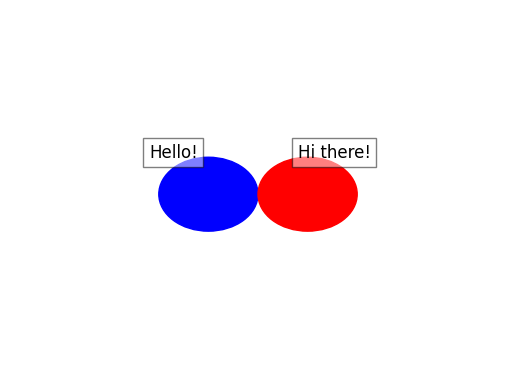

user_proxy (to chatbot):

***** Response from calling function "python" *****
(0.0, 1.0, 0.0, 1.0)
***************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

The two agents have been drawn, each represented as a circle, and an example of their dialogue is displayed above them. Since `plt.show()` was not to be included, the plot is not displayed here, but the agents along with their dialogue would appear within the figure's coordinate system, which extends from 0 to 1 on both the x and y axes.

--------------------------------------------------------------------------------
user_proxy (to chatbot):



--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Draw two agents chatting with each other with an example dialog. Don't add plt.show().", 'role': 'assistant'}, {'function_call': {'arguments': '{\n  "cell": "import matplotlib.pyplot as plt\\nimport numpy as np\\n\\nfig, ax = plt.subplots()\\n\\n# Define the agents as circles\\nagent1 = plt.Circle((0.4, 0.5), 0.1, color=\'blue\')\\nagent2 = plt.Circle((0.6, 0.5), 0.1, color=\'red\')\\n\\n# Draw the agents\\nax.add_artist(agent1)\\nax.add_artist(agent2)\\n\\n# Example dialog boxes\\nplt.text(0.28, 0.6, \\"Hello!\\", fontsize=12, bbox=dict(facecolor=\'white\', alpha=0.5))\\nplt.text(0.58, 0.6, \\"Hi there!\\", fontsize=12, bbox=dict(facecolor=\'white\', alpha=0.5))\\n\\n# Set the limits and remove axes\\nax.set_xlim(0, 1)\\nax.set_ylim(0, 1)\\nax.axis(\'off\')\\n"\n}', 'name': 'python'}, 'content': None, 'role': 'assistant'}, {'content': '(0.0, 1.0, 0.0, 1.0)', 'name': 'python', 'role': 'function'}, {'content': "The two agents have been

In [4]:
llm_config = {
    "model": "gpt-4-1106-preview",
    "functions": [
        {
            "name": "python",
            "description": "run cell in ipython and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "cell": {
                        "type": "string",
                        "description": "Valid Python cell to execute.",
                    }
                },
                "required": ["cell"],
            },
        },
        {
            "name": "sh",
            "description": "run a shell script and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "script": {
                        "type": "string",
                        "description": "Valid shell script to execute.",
                    }
                },
                "required": ["script"],
            },
        },
    ],
    "config_list": config_list,
    "timeout": 120,
}

chatbot = CompressibleAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
    compress_config={
        "mode": "COMPRESS",
        "trigger_count": 600,  # set this to a large number for less frequent compression
        "verbose": True,  # set this to False to suppress the compression log
        "leave_last_n": 2,
    },
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)


def exec_python(cell):
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log


def exec_sh(script):
    return user_proxy.execute_code_blocks([("sh", script)])


# register the functions
user_proxy.register_function(
    function_map={
        "python": exec_python,
        "sh": exec_sh,
    }
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)

## Example 3
This example is from [agent_chat_web_info.ipynb](https://github.com/microsoft/autogen/blob/main/notebook/agentchat_web_info.ipynb). 
We use this example to demonstrate how to pass in a customized compression function. We pass in an compression function `constrain_num_messages`, which constrains the number of messages to be 3 or less. 
The customized function should accept a list of messages as input and return a tuple of `(is_success: bool, compressed_messages: List[Dict])`.

In [5]:
def constrain_num_messages(messages):
    """Constrain the number of messages to 3.

    This is an example of a customized compression function.

    Returns:
        bool: whether the compression is successful.
        list: the compressed messages.
    """
    if len(messages) <= 3:
        # do nothing
        return False, None

    # save the first and last two messages
    return True, messages[:1] + messages[-2:]


# create a CompressibleAgent instance named "assistant"
assistant = CompressibleAgent(
    name="assistant",
    llm_config={
        "timeout": 600,
        "cache_seed": 43,
        "config_list": config_list,
        "model": "gpt-4-1106-preview",
    },
    compress_config={
        "mode": "CUSTOMIZED",
        "compress_function": constrain_num_messages,  # this is required for customized compression
        "trigger_count": 1600,
    },
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="TERMINATE",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE")
    or x.get("content", "").rstrip().endswith("TERMINATE."),
    code_execution_config={
        "work_dir": "web",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    system_message="""Reply TERMINATE if the task has been solved at full satisfaction.
Otherwise, reply CONTINUE, or the reason why the task is not solved yet.""",
)

user_proxy.initiate_chat(
    assistant,
    message="""Show me the YTD gain of 10 largest technology companies as of today.""",
)

user_proxy (to assistant):

Show me the YTD gain of 10 largest technology companies as of today.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To compute the Year-To-Date (YTD) gains of the 10 largest technology companies, I can fetch the latest stock price and the closing price from the last trading day of the previous year. Then calculate the percentage increase for each company.

First, we should fetch the current stock prices and the closing prices as of the last trading day of the previous year for these companies. For this, we can use a financial data API like Alpha Vantage, Yahoo Finance, or similar, which would require an API key and internet access, but I can't perform actions that require internet access.

Instead, I will provide you with Python code that you'd need to run on your local machine. This code utilizes the `yfinance` Python library, which is widely used for retrieving historical market data from Yahoo

ChatResult(chat_id=None, chat_history=[{'content': 'Show me the YTD gain of 10 largest technology companies as of today.', 'role': 'assistant'}, {'content': 'It looks like an error occurred while retrieving data for FB, which stands for Facebook. This can happen if the ticker symbol has changed or if there was an issue with the data for the date range we were trying to fetch. Facebook, Inc. has been renamed to Meta Platforms, Inc., and its stock symbol is now "META." \n\nI will update the list of technology companies to include "META" instead of "FB" and run the code again:\n\n```python\n# filename: ytd_gains_updated.py\n\nimport yfinance as yf\nfrom datetime import datetime, timedelta\n\ndef get_last_valid_trading_day(year):\n    last_day = datetime(year, 12, 31)\n    # Start moving backwards from December 31st to find the last valid trading day of the year\n    while True:\n        stock_data = yf.download(\'SPY\', start=last_day.strftime(\'%Y-%m-%d\'), end=(last_day + timedelta(days